In [1]:
# Starting from df_cleaned DataFrame from prev Notebook

import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy


df_cleaned = pd.read_excel("./cleaned_weather_classif_data.xlsx", engine="openpyxl")
df_cleaned.columns = df_cleaned.columns.str.strip()

In [2]:
df_cleaned

,Temperature (Celsius),"Humidity (?relative, %)",Wind Speed (km/h),Precipitation (%),Cloud Cover,Atmospheric Pressure (hPa),UV Index,Season,Visibility (km),Location,Weather Type
0,14,73,9.5,82,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39,96,8.5,71,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30,64,7.0,16,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38,83,1.5,82,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27,74,17.0,66,overcast,990.67,1,Winter,2.5,mountain,Rainy
...,...,...,...,...,...,...,...,...,...,...,...
12313,10,74,14.5,71,overcast,1003.15,1,Summer,1.0,mountain,Rainy
12314,-1,76,3.5,23,cloudy,1067.23,1,Winter,6.0,coastal,Snowy
12315,30,77,5.5,28,overcast,1012.69,3,Autumn,9.0,coastal,Cloudy
12316,3,76,10.0,94,overcast,984.27,0,Winter,2.0,inland,Snowy


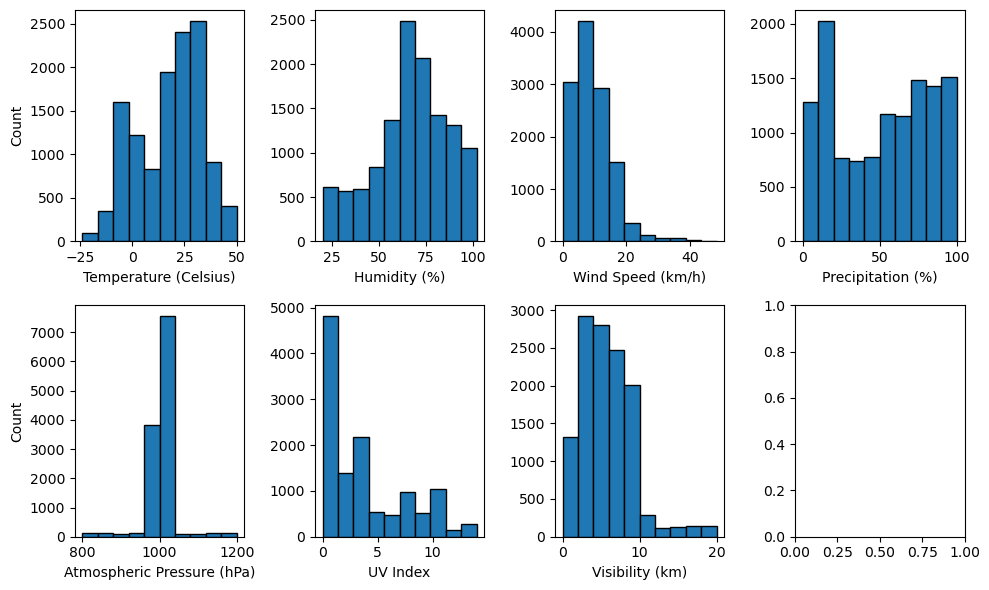

In [3]:
# Here examining histogram of each (numerical) feature to assess which scaling technique might work best.

# YES in hindsight I should have specified auto binning in the parameters, to get perhaps more accurate/true distribs
# BUT for now that's ok. I've made my scaling choices. I'm gonna stick with them and evaluate them based on model's
# performance.

# Yes sure, could create for loop to automate the generation of histograms of all the columns with 
# non-Boolean values: ie all the columns NOT one-hot encoded. But for now I'll keep it manual



fig, axes = plt.subplots(2, 4, figsize=(10,6))

# 1st row
axes[0, 0].hist(df_cleaned["Temperature (Celsius)"], edgecolor='black')
axes[0, 1].hist(df_cleaned["Humidity (?relative, %)"], edgecolor='black')
axes[0, 2].hist(df_cleaned["Wind Speed (km/h)"], edgecolor='black')
axes[0, 3].hist(df_cleaned["Precipitation (%)"], edgecolor='black')

# 2nd row
axes[1, 0].hist(df_cleaned["Atmospheric Pressure (hPa)"], edgecolor='black')
axes[1, 1].hist(df_cleaned["UV Index"], edgecolor='black')
axes[1, 2].hist(df_cleaned["Visibility (km)"], edgecolor='black')

# Labels
axes[0, 0].set_xlabel("Temperature (Celsius)")
axes[0, 1].set_xlabel("Humidity (%)")
axes[0, 2].set_xlabel("Wind Speed (km/h)")
axes[0, 3].set_xlabel("Precipitation (%)")

axes[1, 0].set_xlabel("Atmospheric Pressure (hPa)")
axes[1, 1].set_xlabel("UV Index")
axes[1, 2].set_xlabel("Visibility (km)")

axes[0, 0].set_ylabel("Count")
axes[1, 0].set_ylabel("Count")

plt.tight_layout()

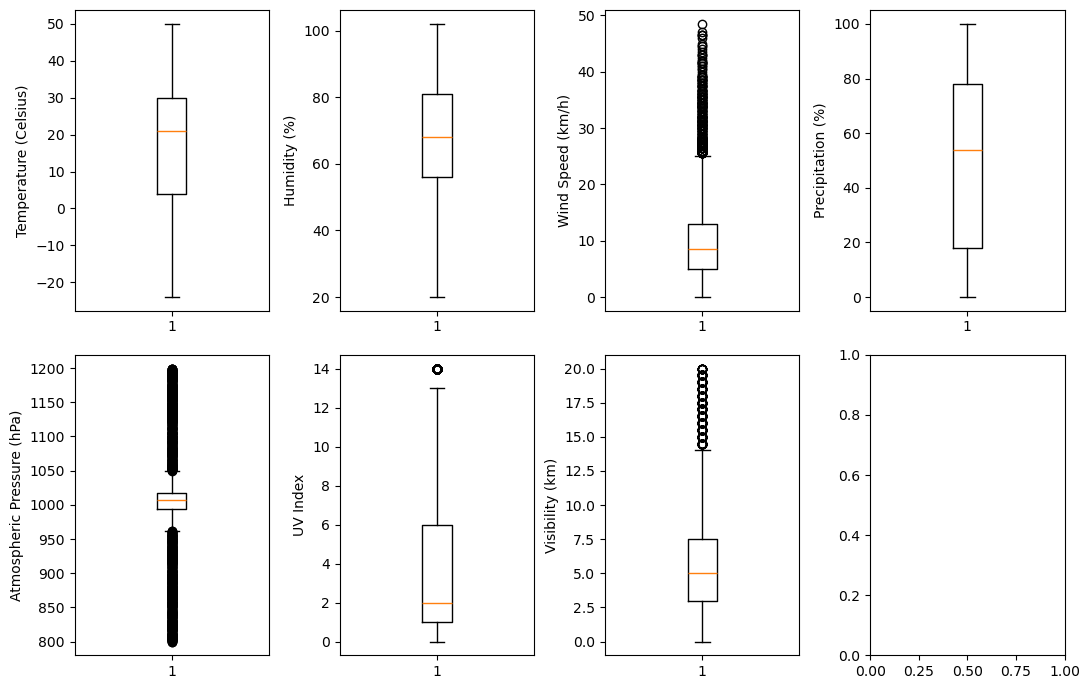

In [4]:
# Box plots of each (numerical) feature to assess outlier severity

# Work out how to make a for loop for this!

fig, axes = plt.subplots(2, 4, figsize=(11, 7))

axes[0, 0].boxplot(df_cleaned["Temperature (Celsius)"])
axes[0, 1].boxplot(df_cleaned["Humidity (?relative, %)"])
axes[0, 2].boxplot(df_cleaned["Wind Speed (km/h)"])
axes[0, 3].boxplot(df_cleaned["Precipitation (%)"])

axes[1, 0].boxplot(df_cleaned["Atmospheric Pressure (hPa)"])
axes[1, 1].boxplot(df_cleaned["UV Index"])
axes[1, 2].boxplot(df_cleaned["Visibility (km)"])

axes[0, 0].set_ylabel("Temperature (Celsius)")
axes[0, 1].set_ylabel("Humidity (%)")
axes[0, 2].set_ylabel("Wind Speed (km/h)")
axes[0, 3].set_ylabel("Precipitation (%)")

axes[1, 0].set_ylabel("Atmospheric Pressure (hPa)")
axes[1, 1].set_ylabel("UV Index")
axes[1, 2].set_ylabel("Visibility (km)")

plt.tight_layout()

Right, so temp, precipitation and UV index would probably all be suitable for quantile transform (non-standard distribtions, few or no outliers)

Wind speed, pressure and visibility probably need robust  (so many outliers) 

Humidity is actually quite Gaussian in distribution, so a simpler method like tddanardisation might be appropriate


In [5]:
# Scaling temp, precip and UV features with quantile transform 

from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer()

temp_precip_UV_qt = qt.fit_transform(df_cleaned[["Temperature (Celsius)", "Precipitation (%)", "UV Index"]])
df_cleaned_numfeatures_qt = pd.DataFrame(temp_precip_UV_qt, columns=["Temperature (Celsius)", 
                                                                "Precipitation (%)", "UV Index"])

In [6]:
df_cleaned_numfeatures_qt

,Temperature (Celsius),Precipitation (%),UV Index
0,0.358859,0.791792,0.446947
1,0.930931,0.662162,0.785285
2,0.756256,0.209710,0.704705
3,0.921421,0.791792,0.785285
4,0.673173,0.614615,0.277277
...,...,...,...
12313,0.281281,0.662162,0.277277
12314,0.173674,0.290290,0.277277
12315,0.756256,0.320821,0.560561
12316,0.239740,0.935936,0.000000


<Axes: xlabel='UV Index', ylabel='Count'>

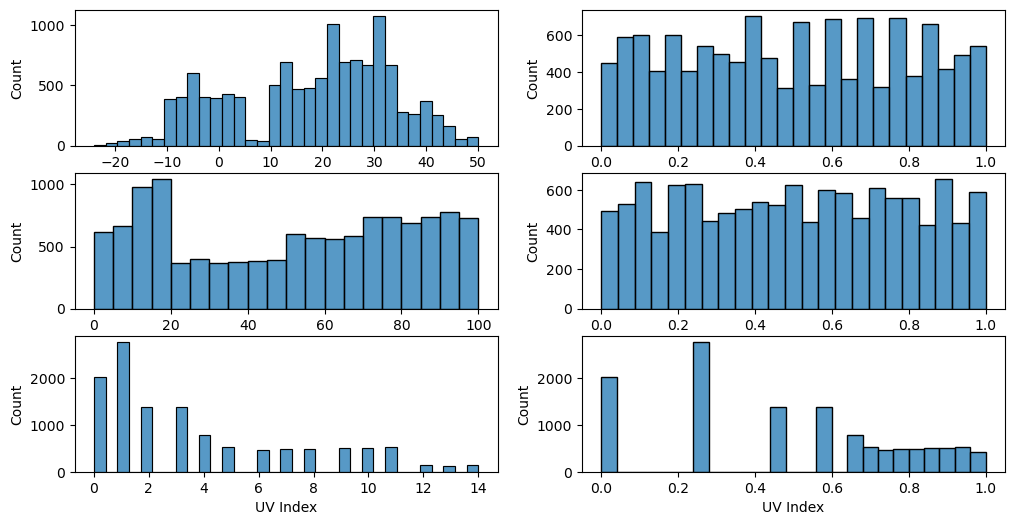

In [7]:
# Comparing the histograms of the temp column before and after qt 

# Looks as if qt has not worked well on UV index. Yes I've not tried specifying Gaussian output. 
# Still probably need another technique, but which one? 

fig, axes = plt.subplots(3, 2, figsize=(12, 6))

sns.histplot(df_cleaned["Temperature (Celsius)"], ax=axes[0, 0])
sns.histplot(df_cleaned_numfeatures_qt["Temperature (Celsius)"], ax=axes[0, 1])

sns.histplot(df_cleaned["Precipitation (%)"], ax=axes[1, 0])
sns.histplot(df_cleaned_numfeatures_qt["Precipitation (%)"], ax=axes[1, 1])

sns.histplot(df_cleaned["UV Index"], ax=axes[2, 0])
sns.histplot(df_cleaned_numfeatures_qt["UV Index"], axes=axes[2, 1])



{'whiskers': [<matplotlib.lines.Line2D at 0x162a893f290>,
 'caps': [<matplotlib.lines.Line2D at 0x162a76eb410>,
 'boxes': [<matplotlib.lines.Line2D at 0x162a8381250>],
 'medians': [<matplotlib.lines.Line2D at 0x162a8383c90>],
 'fliers': [<matplotlib.lines.Line2D at 0x162a8390550>],
 'means': []}

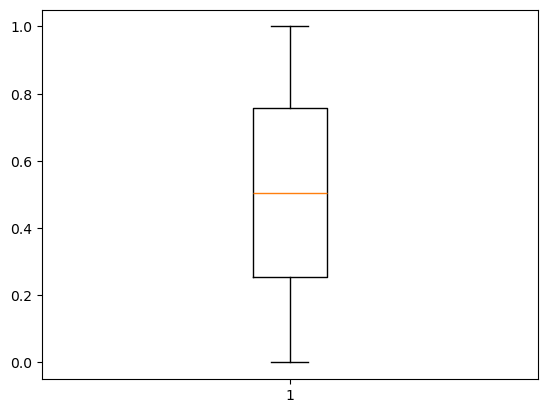

In [8]:
plt.boxplot(df_cleaned_numfeatures_qt["Temperature (Celsius)"])

Now that is a symmetrical-looking box plot!

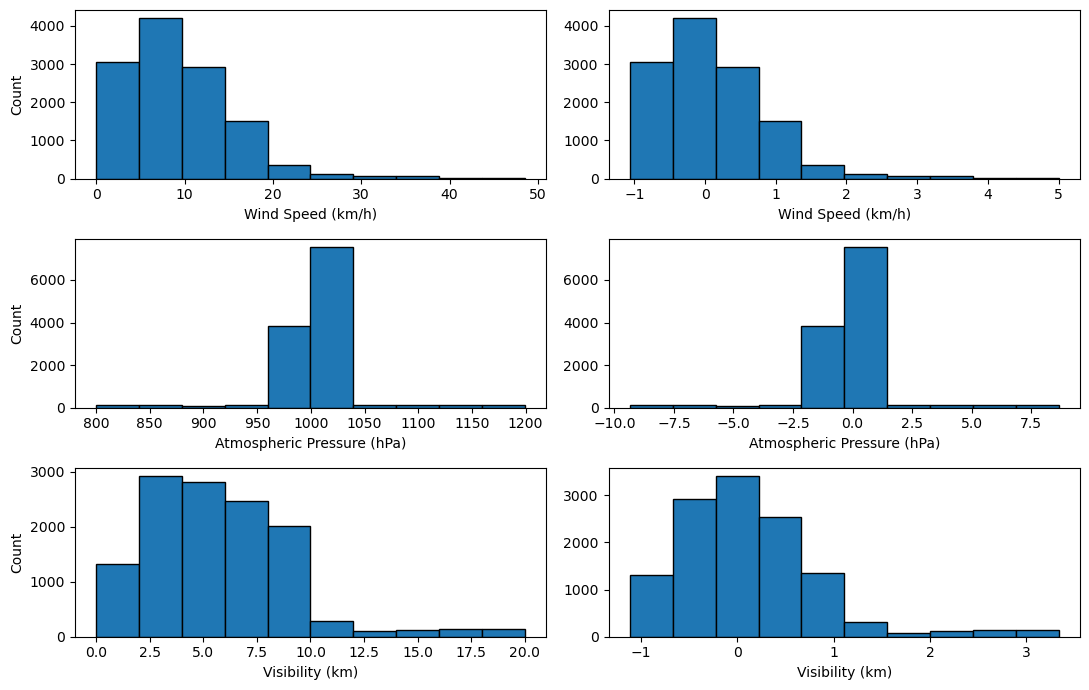

In [9]:
# Scaling wind, press. and visib. features with robust scaler, then plotting before-after histogram comparison

from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
wind_press_visib_rs = rs.fit_transform(df_cleaned[["Wind Speed (km/h)", "Atmospheric Pressure (hPa)", "Visibility (km)"]])
df_cleaned_numfeatures_rs = pd.DataFrame(wind_press_visib_rs, columns=["Wind Speed (km/h)", "Atmospheric Pressure (hPa)", "Visibility (km)"])


fig, axes = plt.subplots(3, 2, figsize=(11, 7))

axes[0, 0].hist(df_cleaned["Wind Speed (km/h)"], edgecolor='black')
axes[0, 1].hist(df_cleaned_numfeatures_rs["Wind Speed (km/h)"], edgecolor='black')

axes[1, 0].hist(df_cleaned["Atmospheric Pressure (hPa)"], edgecolor='black')
axes[1, 1].hist(df_cleaned_numfeatures_rs["Atmospheric Pressure (hPa)"], edgecolor='black')

axes[2, 0].hist(df_cleaned["Visibility (km)"], edgecolor='black')
axes[2, 1].hist(df_cleaned_numfeatures_rs["Visibility (km)"], edgecolor='black')

axes[0, 0].set_xlabel("Wind Speed (km/h)")
axes[0, 1].set_xlabel("Wind Speed (km/h)")

axes[1, 0].set_xlabel("Atmospheric Pressure (hPa)")
axes[1, 1].set_xlabel("Atmospheric Pressure (hPa)")

axes[2, 0].set_xlabel("Visibility (km)")
axes[2, 1].set_xlabel("Visibility (km)")

axes[0, 0].set_ylabel("Count")
axes[1, 0].set_ylabel("Count")
axes[2, 0].set_ylabel("Count")

plt.tight_layout()

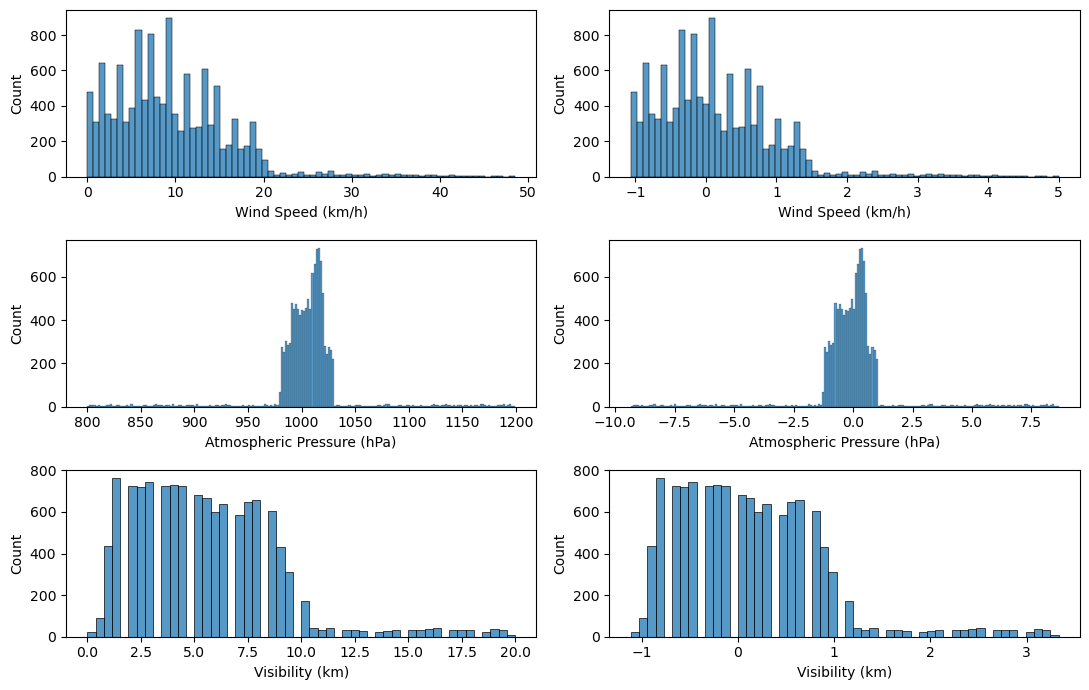

In [10]:
# Before-after histograms using SNS instead of PLT

fig, axes = plt.subplots(3, 2, figsize=(11, 7))

sns.histplot(df_cleaned["Wind Speed (km/h)"], ax=axes[0, 0])
sns.histplot(df_cleaned_numfeatures_rs["Wind Speed (km/h)"], ax=axes[0, 1])

sns.histplot(df_cleaned["Atmospheric Pressure (hPa)"], ax=axes[1, 0])
sns.histplot(df_cleaned_numfeatures_rs["Atmospheric Pressure (hPa)"], ax=axes[1, 1])

sns.histplot(df_cleaned["Visibility (km)"], ax=axes[2, 0])
sns.histplot(df_cleaned_numfeatures_rs["Visibility (km)"], ax=axes[2, 1])

plt.tight_layout()

Be careful re the gaps, ie 0-frequency bins, as seen in above visib and uv histograms. 
1 First try to understand why the histo is like this: natural gaps or data granularity (the latter meaning insufficiently precise measurement, eg only whole numbers, meaning gaps could appear where fractional values don't exist)
2 Many scaling techniques will struggle to smooth over (fill) these gaps
3 The gaps can hinder the model's ability to generalise to new data within the missing range(s).
  3.1 So you need to know whether values in the missing range(s) will occur in future unseen data or not.
4 (Don't understand this point so well but anyway...) Large gaps can introduce bias or misrep during scaling because the algo might overweight ranges with dense values and underweight sparse or missing ranges.

Possible solutions
1 Do nothing
2 Group differently: eg if precise values are not as important as general range, you could group values into cats like "Low", "Med" and "High".
3 Others!

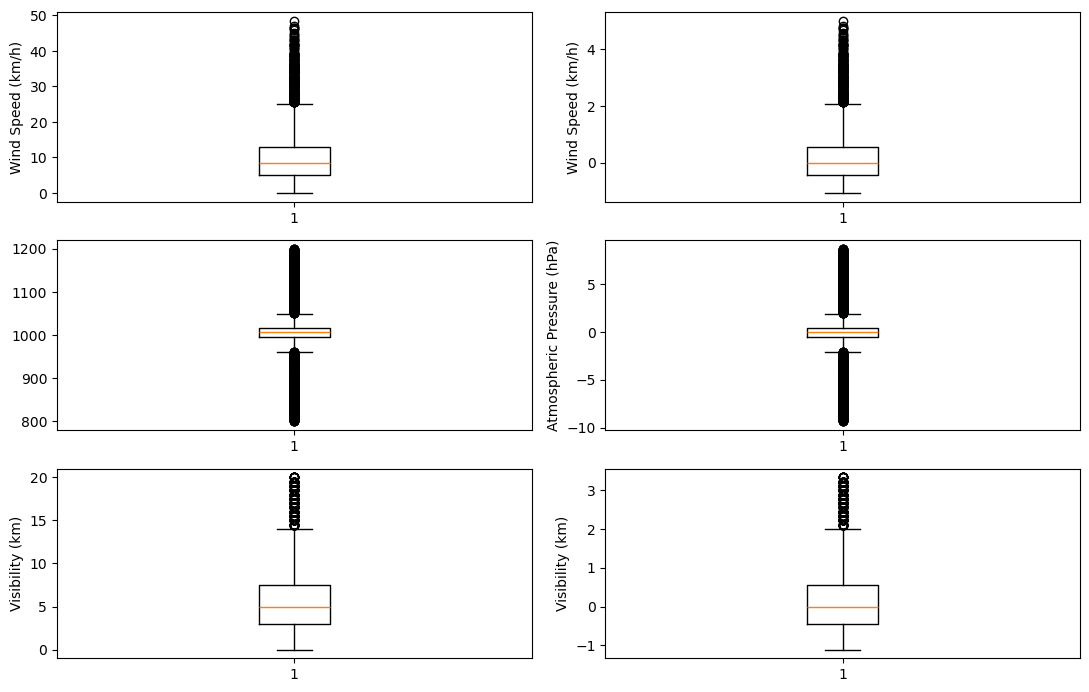

In [11]:
# Same but with box plots

fig, axes = plt.subplots(3, 2, figsize=(11, 7))

axes[0, 0].boxplot(df_cleaned["Wind Speed (km/h)"])
axes[0, 1].boxplot(df_cleaned_numfeatures_rs["Wind Speed (km/h)"])

axes[1, 0].boxplot(df_cleaned["Atmospheric Pressure (hPa)"])
axes[1, 1].boxplot(df_cleaned_numfeatures_rs["Atmospheric Pressure (hPa)"])

axes[2, 0].boxplot(df_cleaned["Visibility (km)"])
axes[2, 1].boxplot(df_cleaned_numfeatures_rs["Visibility (km)"])

axes[0, 0].set_ylabel("Wind Speed (km/h)")
axes[0, 1].set_ylabel("Wind Speed (km/h)")

axes[1, 1].set_ylabel("Atmospheric Pressure (hPa)")
axes[1, 1].set_ylabel("Atmospheric Pressure (hPa)")

axes[2, 0].set_ylabel("Visibility (km)")
axes[2, 1].set_ylabel("Visibility (km)")

plt.tight_layout()

So only the scales have changed, not the distributions, IQR etc of the values. Bizarre

<Axes: xlabel='Humidity (%)', ylabel='Count'>

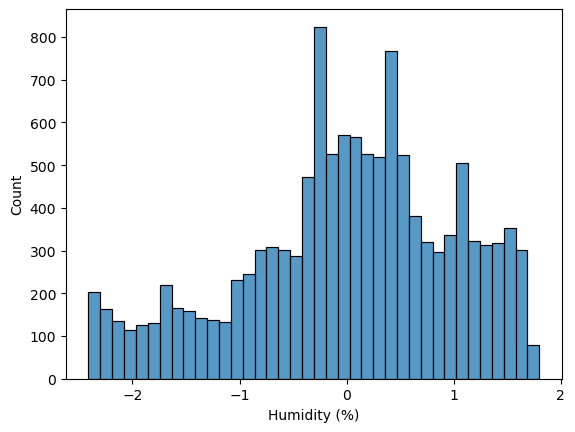

In [12]:
# Z-score standardization of humidity feature (the approx Gaussian one)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
humid_ss = ss.fit_transform(df_cleaned[["Humidity (?relative, %)"]])
df_cleaned_humid_ss = pd.DataFrame(humid_ss, columns=["Humidity (%)"])

sns.histplot(df_cleaned_humid_ss["Humidity (%)"])
                                        

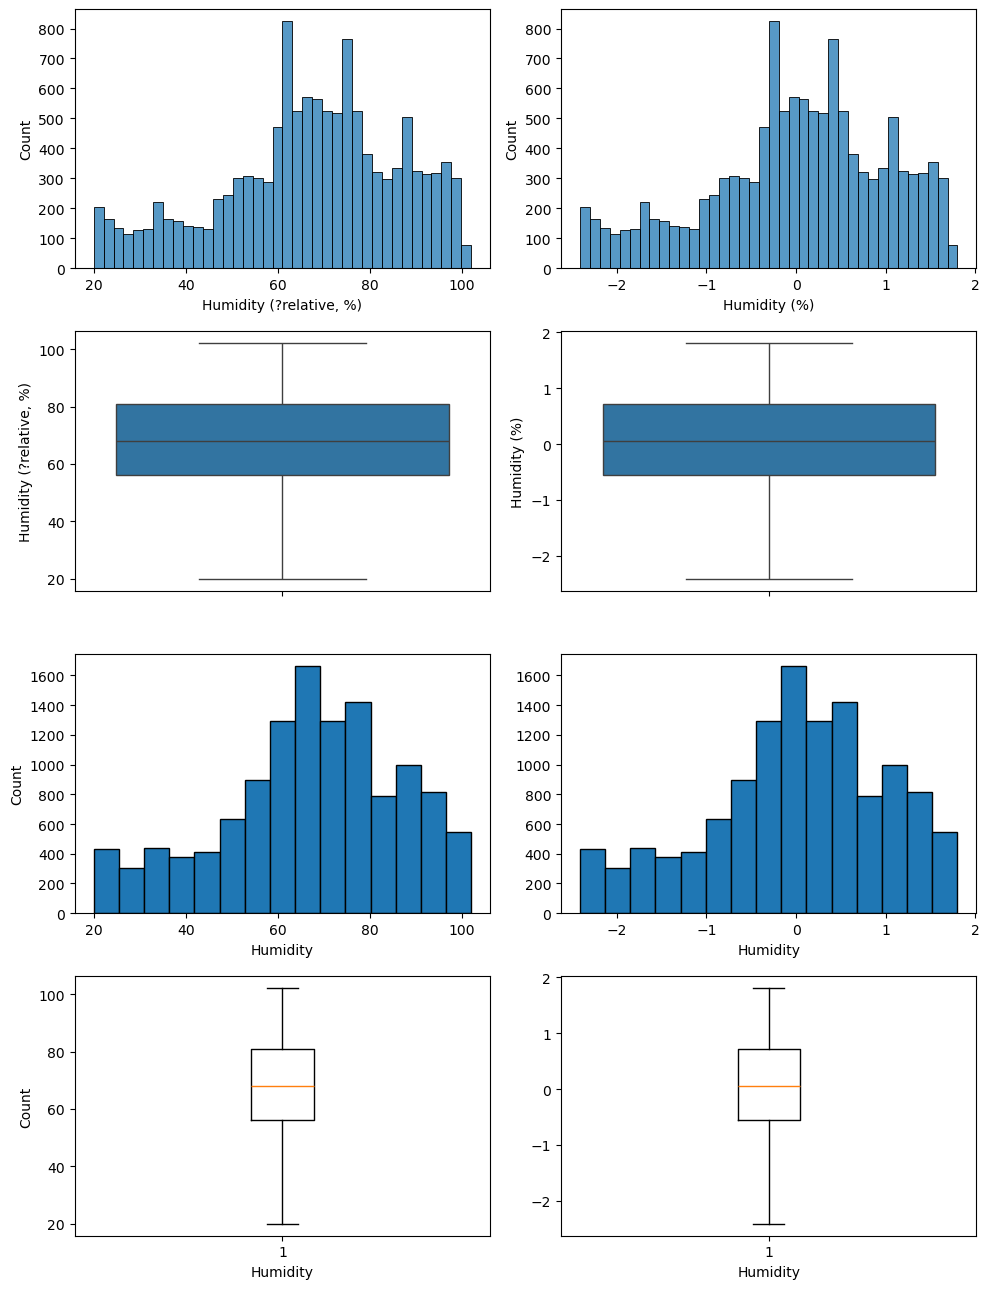

In [13]:
# Z-score scaled humidity before and after: SNS (auto selection of bin width), box plot, PLT (manual bin width selection)

fig, axes = plt.subplots(4, 2, figsize=(10,13))

sns.histplot(df_cleaned["Humidity (?relative, %)"], ax=axes[0, 0])
sns.histplot(df_cleaned_humid_ss["Humidity (%)"], ax=axes[0, 1])

sns.boxplot(df_cleaned["Humidity (?relative, %)"], ax=axes[1, 0])
sns.boxplot(df_cleaned_humid_ss["Humidity (%)"], ax=axes[1, 1])

axes[2, 0].hist(df_cleaned["Humidity (?relative, %)"], edgecolor='black', bins=15)
axes[2, 1].hist(df_cleaned_humid_ss["Humidity (%)"], edgecolor='black', bins=15)

axes[3, 0].boxplot(df_cleaned["Humidity (?relative, %)"])
axes[3, 1].boxplot(df_cleaned_humid_ss["Humidity (%)"])

axes[2, 0].set_xlabel("Humidity")
axes[2, 1].set_xlabel("Humidity")

axes[3, 0].set_xlabel("Humidity")
axes[3, 1].set_xlabel("Humidity")

axes[2, 0].set_ylabel("Count")
axes[3, 0].set_ylabel("Count")

plt.tight_layout()

Humidity (also) unchanged in distribution after scaling. This iS TO BE EXPECTED WITH Z-SCORE TECHNIQUE. (GPT)

In [14]:
# Merging the dfs is simple!

df_numfeatures_scaled = pd.concat([df_cleaned_numfeatures_qt, df_cleaned_numfeatures_rs, df_cleaned_humid_ss], axis=1)

# But now remove UV column, because too many empty histo bins and I don't want to fix this now

df_numfeatures_scaled.drop(["UV Index"], axis=1, inplace=True)
df_numfeatures_scaled

,Temperature (Celsius),Precipitation (%),Wind Speed (km/h),Atmospheric Pressure (hPa),Visibility (km),Humidity (%)
0,0.358859,0.791792,0.1250,0.153222,-0.333333,0.310904
1,0.930931,0.662162,0.0000,0.180712,1.111111,1.492028
2,0.756256,0.209710,-0.1875,0.509238,0.111111,-0.151275
3,0.921421,0.791792,-0.8750,0.848580,-0.888889,0.824436
4,0.673173,0.614615,1.0625,-0.754845,-0.555556,0.362257
...,...,...,...,...,...,...
12313,0.281281,0.662162,0.7500,-0.192429,-0.888889,0.362257
12314,0.173674,0.290290,-0.6250,2.695358,0.222222,0.464964
12315,0.756256,0.320821,-0.3750,0.237494,0.888889,0.516317
12316,0.239740,0.935936,0.1875,-1.043263,-0.666667,0.464964


In [15]:
# Making new DataFrames with just the categorical features

df_catfeatures_wtarget = df_cleaned[["Cloud Cover", "Season", "Location", "Weather Type"]]
df_catfeatures_wouttarget = df_cleaned[["Cloud Cover", "Season", "Location"]]

In [16]:
# One-hot encoding the categorical features. With the features, false ordinality IS a problem and must be avoided.

df_catfeatures_wtarget = pd.get_dummies(df_catfeatures_wtarget, columns = ["Cloud Cover", "Season", "Location"])
df_catfeatures_wouttarget = pd.get_dummies(df_catfeatures_wouttarget, columns = ["Cloud Cover", "Season", "Location"])

In [17]:
# Label encoding the target variable. With the target variable, false ordinality is not a problem AND it must be fed to the 
# model as a 1D array, hence label encoding. 

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_catfeatures_wtarget["Weather Type"] = le.fit_transform(df_catfeatures_wtarget["Weather Type"])

In [18]:
# Concat scaled numerical and encoded categorical features

df_ready_wtarget = pd.concat([df_numfeatures_scaled, df_catfeatures_wtarget], axis=1)
df_ready_wouttarget = pd.concat([df_numfeatures_scaled, df_catfeatures_wouttarget], axis=1)

In [19]:
df_ready_wtarget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12318 entries, 0 to 12317
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Temperature (Celsius)       12318 non-null  float64
 1   Precipitation (%)           12318 non-null  float64
 2   Wind Speed (km/h)           12318 non-null  float64
 3   Atmospheric Pressure (hPa)  12318 non-null  float64
 4   Visibility (km)             12318 non-null  float64
 5   Humidity (%)                12318 non-null  float64
 6   Weather Type                12318 non-null  int32  
 7   Cloud Cover_clear           12318 non-null  bool   
 8   Cloud Cover_cloudy          12318 non-null  bool   
 9   Cloud Cover_overcast        12318 non-null  bool   
 10  Cloud Cover_partly cloudy   12318 non-null  bool   
 11  Season_Autumn               12318 non-null  bool   
 12  Season_Spring               12318 non-null  bool   
 13  Season_Summer               123

In [20]:
df_ready_wouttarget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12318 entries, 0 to 12317
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Temperature (Celsius)       12318 non-null  float64
 1   Precipitation (%)           12318 non-null  float64
 2   Wind Speed (km/h)           12318 non-null  float64
 3   Atmospheric Pressure (hPa)  12318 non-null  float64
 4   Visibility (km)             12318 non-null  float64
 5   Humidity (%)                12318 non-null  float64
 6   Cloud Cover_clear           12318 non-null  bool   
 7   Cloud Cover_cloudy          12318 non-null  bool   
 8   Cloud Cover_overcast        12318 non-null  bool   
 9   Cloud Cover_partly cloudy   12318 non-null  bool   
 10  Season_Autumn               12318 non-null  bool   
 11  Season_Spring               12318 non-null  bool   
 12  Season_Summer               12318 non-null  bool   
 13  Season_Winter               123

Keeping these lines -- df to spreadsheet -- as Markdown b/c these files already exist now; don't want duplicates 
df_ready_wtarget.to_excel("wc_data_ready_features_target.xlsx", index=False)
df_ready_wouttarget.to_excel("wc_data_ready_featuresonly.xlsx", index=False)